<a href="https://colab.research.google.com/github/MahlerTom/Siamese-Neural-Networks/blob/master/IntroToDeepEx02_Tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

The dataset was uploaded to [MahlerTom/Siamese-Neural-Networks](https://github.com/MahlerTom/Siamese-Neural-Networks), so we first need to clone the repository, with the data. To make things easier, we also define:

*   `repo_path` - the repository path (this should be cross platrform since we use `os` module)
*   `train_path` - the train dataset path
*   `test_path` - the test dataset path



In [1]:
import os

# Clone the entire repo.
!git clone -s git://github.com/MahlerTom/Siamese-Neural-Networks.git Siamese-Neural-Networks
repo_path = os.path.join(os.getcwd(), 'Siamese-Neural-Networks')
train_path = os.path.join(repo_path, 'data', 'train')
test_path = os.path.join(repo_path, 'data', 'test')

Cloning into 'Siamese-Neural-Networks'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 19072 (delta 7), reused 15 (delta 2), pack-reused 19048
Receiving objects: 100% (19072/19072), 192.48 MiB | 33.51 MiB/s, done.
Resolving deltas: 100% (42/42), done.


Next, we install TensorFlow 2.0 and import it

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

     |████████████████████████████████| 79.9MB 342kB/s 
     |████████████████████████████████| 3.0MB 39.0MB/s 
     |████████████████████████████████| 419kB 46.6MB/s 
     |████████████████████████████████| 61kB 22.9MB/s 


# Preparing the dataset

Before we begin our training, we need to prepare the dataset. Since we are using TensorFlow 2.0, we will make use of its functions. We followed the guide at: [https://www.tensorflow.org/alpha/tutorials/load_data/images](https://www.tensorflow.org/alpha/tutorials/load_data/images)

## Prepare data paths
Tensorflow makes use of smart functions that can load images given their paths. In addition, we received `trainPairs.txt` and `testPairs.txt`, which include the labels. 

The data structure is as follows: `(left_img_path, right_img_path, label)`

Thus, the following function will create it.

In [163]:
import random
import IPython.display as display

def load_data(data_path, labels_file, print_imgs=3):
  import pathlib
  
  data_root = pathlib.Path(data_path)
  
  data_paths = list(data_root.glob('*'))
  data_paths = [str(path) for path in data_paths]
  random.shuffle(data_paths)
  data_count = len(data_paths)
  print('Loaded', data_count, 'image paths')
  if print_imgs > 0:
    print('##########################################')
    print('Printing Example Images')
    print()
    
    for n in range(print_imgs):
      image_path = random.choice(data_paths)
      display.display(display.Image(image_path))
      print(image_path.split('/')[-1][:-4])
      print()
      
    print('##########################################')
    
  rel_path = os.path.join('/', *data_paths[0].split('/')[:-1])
#   data_names = [ tip.split('/')[-1][:-4] for tip in data_paths ]
#   data_paths_names_dict = { name: os.path.join(rel_path, name + '.jpg') for name in data_names }
    
  data_paths_paths = list()
  with open(labels_file) as lf:
    for l in lf:
      l = l[:-1].split('\t')
      if len(l) in [3, 4]:
        left = os.path.join(rel_path, l[0] + '_' + l[1].zfill(4) + '.jpg')
        if len(l) == 3:        
          right = os.path.join(rel_path, l[0] + '_' + l[2].zfill(4) + '.jpg')
          data_paths_paths.append(tuple((left, right, 1)))
        if len(l) == 4:
          right = os.path.join(rel_path, l[2] + '_' + l[3].zfill(4) + '.jpg')
          data_paths_paths.append(tuple((left, right, 0)))
        
#   return data_paths_names_dict, labels
  return data_paths_paths

def image_name(path):
  return path.split('/')[-1][:-4]


# train_paths_names_dict, train_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'trainPairs.txt'), print_imgs=0)
# test_paths_names_dict, test_labels = load_data(test_path, labels_file=os.path.join(repo_path, 'testPairs.txt'), print_imgs=0)

train_paths_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'trainPairs.txt'), print_imgs=0)
test_paths_labels = load_data(test_path, labels_file=os.path.join(repo_path, 'testPairs.txt'), print_imgs=0)

label_name = ['Different', 'Same']

# print(list(train_paths_names_dict.keys())[:3])
# print(list(train_paths_names_dict.values())[:3])
# print(train_labels[:3])
print(train_paths_labels[:3])
print([tuple((image_name(p[0]), image_name(p[1]), label_name[p[2]])) for p in train_paths_labels[:3]])

Loaded 6685 image paths
Loaded 2741 image paths
[('/content/Siamese-Neural-Networks/data/train/Aaron_Peirsol_0001.jpg', '/content/Siamese-Neural-Networks/data/train/Aaron_Peirsol_0002.jpg', 1), ('/content/Siamese-Neural-Networks/data/train/Aaron_Peirsol_0003.jpg', '/content/Siamese-Neural-Networks/data/train/Aaron_Peirsol_0004.jpg', 1), ('/content/Siamese-Neural-Networks/data/train/Aaron_Sorkin_0001.jpg', '/content/Siamese-Neural-Networks/data/train/Aaron_Sorkin_0002.jpg', 1)]
[('Aaron_Peirsol_0001', 'Aaron_Peirsol_0002', 'Same'), ('Aaron_Peirsol_0003', 'Aaron_Peirsol_0004', 'Same'), ('Aaron_Sorkin_0001', 'Aaron_Sorkin_0002', 'Same')]


## Load and Preprocess image using TF
These function loads images as tensors, and lay the groundwork for preprocessing

In [0]:
def preprocess_image(img_raw, norm=None, resize=None):
  img_tensor = tf.image.decode_image(img_raw)
#   print(img_tensor.shape)
#   print(img_tensor.dtype)

  if resize is not None:
    img_tensor = tf.image.resize(img_tensor, resize) # [192, 192]
#     print(img_tensor.shape)
  if norm is not None:
    img_tensor /= norm # 255.0
#     print(img_tensor.numpy().min())
#     print(img_tensor.numpy().max())
    
  return img_tensor
  
def load_and_preprocess_image(path, norm=None, resize=None):
  img_raw = tf.io.read_file(img_path)
#   print(repr(img_raw)[:100]+"...")
  return preprocess_image(img_raw, norm=norm, resize=resize)

### Testing `load_and_preprocess_image` [collapse]

(250, 250, 1)
(250, 250, 1)



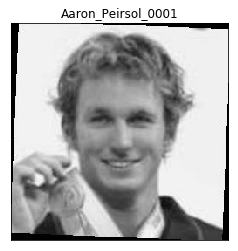

In [192]:
import matplotlib.pyplot as plt

left_train_paths = [p[0] for p in train_paths_labels]
img_path = left_train_paths[0]
# print(img_path)
# label = all_image_labels[0]

plt.imshow(np.squeeze(load_and_preprocess_image(img_path, resize=[250,250])), cmap='gray', vmin=0, vmax=255)
plt.grid(False)
plt.title(image_name(img_path))
plt.xticks([])
plt.yticks([])
print()

## Creating Datasets using `tf.data.Dataset.from_tensor_slices`

In [0]:
def create_image_ds(image_paths, norm=None, resize=None):
  path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
  # print(path_ds)
  image_ds = path_ds.map(lambda path: load_and_preprocess_image(path, norm=norm, resize=resize), num_parallel_calls=AUTOTUNE)
  return image_ds

def create_label_ds(labels, dtype=tf.bool):
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.bool))
  return label_ds

#### Testing `create_image_ds` [collapse]

<ParallelMapDataset shapes: <unknown>, types: tf.uint8>


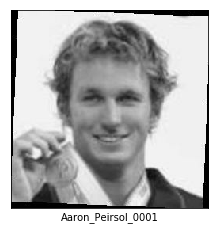

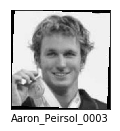

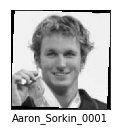

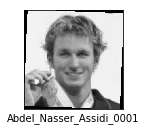

Same
Same
Same
Same
Same
Same
Same
Same
Same
Same


In [196]:
import matplotlib.pyplot as plt

left_train_paths = [ p[0] for p in train_paths_labels ]
image_ds = create_image_ds(left_train_paths)
print(image_ds)

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(np.squeeze(image), cmap='gray', vmin=0, vmax=255)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(image_name(left_train_paths[n]))
  plt.show()
  
labels = [ p[2] for p in train_paths_labels ]
label_ds = create_label_ds(labels)
for l in label_ds.take(10):
  print(label_names[int(l.numpy())])

#### Loading Datasets and labels


In [168]:
train_ds_left = create_image_ds([ p[0] for p in train_paths_labels ])
train_ds_right = create_image_ds([ p[1] for p in train_paths_labels ])
train_ds_labels = create_label_ds([ p[2] for p in train_paths_labels ])
train_ds = tf.data.Dataset.zip((train_ds_left, train_ds_right, train_ds_labels))
print(train_ds)

test_ds_left = create_image_ds([ p[0] for p in test_labels ])
test_ds_right = create_image_ds([ p[1] for p in test_labels ])
test_ds_labels = create_label_ds([ p[2] for p in test_labels ])
test_ds = tf.data.Dataset.zip((test_ds_left, test_ds_right, test_ds_labels))
print(test_ds)

<ZipDataset shapes: (<unknown>, <unknown>, ()), types: (tf.uint8, tf.uint8, tf.bool)>
<ZipDataset shapes: (<unknown>, <unknown>, ()), types: (tf.uint8, tf.uint8, tf.bool)>


## Basic methods for training
To train a model with this dataset you will want the data:

*   To be well shuffled.
*   To be batched.
*   To repeat forever.
*   Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [172]:
BATCH_SIZE = 32
buffer_size = len(train_paths_labels)

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = train_ds.shuffle(buffer_size=buffer_size)
ds = ds.repeat()
ds = ds.batch(batch_size=BATCH_SIZE)

# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: (<unknown>, <unknown>, (None,)), types: (tf.uint8, tf.uint8, tf.bool)>

There are a few things to note here:

1.   The order is important.

*   A `.shuffle` after a `.repeat` would shuffle items across epoch boundaries (some items will be seen twice before others are seen at all).
*   A `.shuffle` after a `.batch` would shuffle the order of the batches, but not shuffle the items across batches.

2. We use a `buffer_size` the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.

3. The shuffle buffer is filled before any elements are pulled from it. So a large `buffer_size` may cause a delay when your `Dataset` is starting.

4. The shuffeled dataset doesn't report the end of a dataset until the shuffle-buffer is completely empty. The `Dataset` is restarted by `.repeat`, causing another wait for the shuffle-buffer to be filled.

This last point can be addressed by using the `tf.data.Dataset.apply` method with the fused `tf.data.experimental.shuffle_and_repeat` function:

In [197]:
ds = train_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=buffer_size))
ds = ds.batch(batch_size=BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds


<PrefetchDataset shapes: (<unknown>, <unknown>, (None,)), types: (tf.uint8, tf.uint8, tf.bool)>

In [0]:
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

In [0]:
train_paths_names_dict

In [0]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

###Import Libararies

In [6]:
import numpy as np
from keras.models import Sequential
import time
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers import Conv3D
from keras.models import Model
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, MaxPooling3D
from keras.layers.core import Lambda, Flatten, Dense
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


###Build Network

In [0]:
def initialize_bias(shape, name=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)
  
def initialize_weights_dense(shape, name=None):
    return np.random.normal(loc = 0.0, scale = 0.2, size = shape)

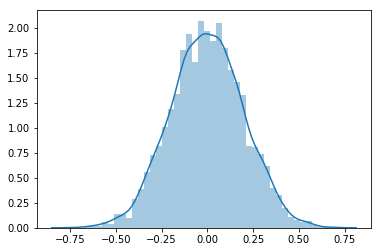

In [8]:
import seaborn as sns
weights = initialize_weights_dense((4096,1))
sns.distplot(weights)

In [0]:
def get_siamese_model(input_shape):
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(2048, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights_dense,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [10]:
model = get_siamese_model((250, 250, 1))

AttributeError: ignored

In [0]:
model.summary()

### UP TO HERE

In [0]:
train_pairs = []
train_names = set()
with open("trainPairs.txt") as train:
  train_files = train.readlines()[1:]
  
for pair in train_files:
  pair = pair[:-1].split('\t')
  if len(pair) == 3:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = name1
    id2 = pair[2].zfill(4)
    
    train_names.add(name1)
    
  elif len(pair) == 4:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = pair[2]
    id2 = pair[3].zfill(4)
    
    train_names.add(name1)
    train_names.add(name2)
  train_pairs.append((name1 + '_' + id1, name2 + '_' + id2))
train_names = list(train_names)

In [0]:
test_pairs = []
test_names = set()
with open("testPairs.txt") as test:
  test_files = test.readlines()[1:]
  
for pair in test_files:
  pair = pair[:-1].split('\t')
  if len(pair) == 3:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = name1
    id2 = pair[2].zfill(4)
    
    test_names.add(name1)
    
  elif len(pair) == 4:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = pair[2]
    id2 = pair[3].zfill(4)
    
    test_names.add(name1)

    test_names.add(name2)
  test_pairs.append((name1 + '_' + id1, name2 + '_' + id2))
test_names = list(test_names)

In [0]:
src = "lfw2/"
train_dir = "data/train/"
test_dir = "data/test/"

for name in train_names:
  print("Moving " + name + "...")
  shutil.copytree(src + name, train_dir + name)
  

Moving Charlotte_Rampling...


FileNotFoundError: ignored